Tutorial notebook hacked together by velandia and nscherf.
It most likely contains a few errors, so please let us know or feel free to add changes.
We will continue working on it ... 
As a starting point, we took most of the inspiration and code from Andrew Glassner: https://github.com/blueberrymusic/Deep-Learning-A-Visual-Approach

Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE. </small>


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neural-data-science-lab/DL-intro-2022/blob/main/MNIST-CNN-Keras.ipynb)

Some hints when using Colab:
- Select GPU or TPU from Runtime (You can also run it with CPU only to see the difference)

In [3]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Setup of the compute environment

In [4]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.utils import to_categorical
keras_backend.set_image_data_format('channels_last')
import visualkeras

from tensorflow.keras.models import Model
from tensorflow.keras import layers

# shape of sample digits
grid_x = 8
grid_y = 3

# Load the MNIST data
Keras already includes the MNIST dataset (http://yann.lecun.com/exdb/mnist/). You can access it via the keras.datasets class.

In [5]:
# number of classes (digits)
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# extra 1-dim for keras, so it can deal with gray pictures (3-dim for RGB pictures)
input_shape = (img_rows, img_cols, 1)

# Normalization of MNIST pictures dataset
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Adding an extra 1-dim for keras
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


### How the dataset looks like
Let's plot a sample of the training dataset in a 3x8 grid.

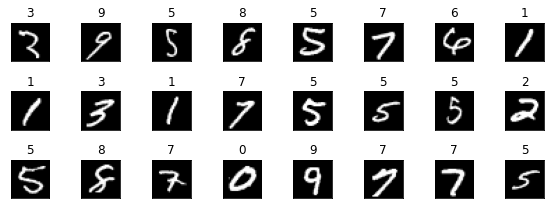

In [7]:
# Plotting random samples from training dataset
plt.figure(figsize=(grid_x, grid_y))

for index in range(grid_x * grid_y):
    plt.subplot(grid_y, grid_x, index + 1)
    img_index = index + 500
    plt.imshow(np.reshape(x_train[img_index],(img_rows,img_cols)),cmap='gray')
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title(str(np.argmax(y_train[img_index])))
plt.tight_layout()
plt.show()

# Set up a simple ConvNet for image classification
In Keras, the function sequential() stacks different kinds of layers, grouping them sequentially to set the neural network architecture.
[More info](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).  

In [8]:
# Hyperparameters of training
batch_size = 128
epochs = 20

# Defining the model in keras
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),                   # input layer of shape (28, 28, 1).
        layers.Conv2D(32, kernel_size=(3, 3),
                         activation='relu'),              # 32 filters, 3x3 kernel size, ReLU activation function.
        layers.Conv2D(64, (3, 3), activation='relu'),        
        layers.MaxPooling2D(pool_size=(2, 2)),            # Maximum pooling of 2x2 size.
        layers.Dropout(0.25),                             # Adding dropout layer, p = 0.25
        layers.Flatten(),                                 
        layers.Dense(128, activation='relu'),             # Flattening layers into a 128-layers
        layers.Dropout(0.5),                              # Adding dropout layer, p = 0.5  
        layers.Dense(num_classes, activation='softmax')   # Output softmax-layer 
    ]
)

###  the model architecture using the visualkeras library.

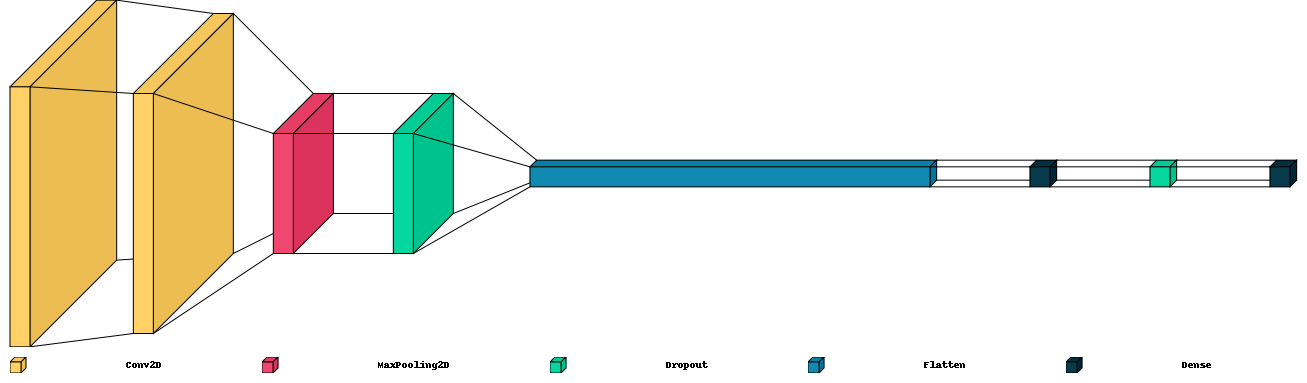

In [9]:
visualkeras.layered_view(model, legend=True, scale_xy=10, scale_z=0.1, draw_volume=True, spacing = 100)

### How many parameters?
Before running the next cell, try to estimate the total number of parameters to be trained in this particular architecture.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

### Time to learn!
Compiling the model let you define some extra configurations: like the loss-function, whether to use an optimizer or not, the metrics you want to follow in order to assess the performance of your model. Additional configurations can be explored [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile).

Let's train the model!

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In keras, the fit() function is a history-type object (here called history_cnn), which records training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable). This history_cnn object let you depict the performance of your model.
[More info](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).

In [12]:
# Training the model on the training dataset.
history_cnn = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,                          # showing the progress of training process in a fancy way  
              validation_data=(x_test, y_test))

# Running the model on the test dataset
print("Evaluating the model on the test dataset")
score = model.evaluate(x_test, y_test, verbose=2) # if verbose is 2, results are shown but no the progress in that fancy way

Epoch 1/20
469/469 [==============================] - 11s 14ms/step - loss: 0.2462 - accuracy: 0.9249 - val_loss: 0.0543 - val_accuracy: 0.9824
Epoch 2/20
469/469 [==============================] - 6s 12ms/step - loss: 0.0865 - accuracy: 0.9743 - val_loss: 0.0378 - val_accuracy: 0.9878
Epoch 3/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0625 - accuracy: 0.9809 - val_loss: 0.0320 - val_accuracy: 0.9889
Epoch 4/20
469/469 [==============================] - 4s 10ms/step - loss: 0.0511 - accuracy: 0.9843 - val_loss: 0.0292 - val_accuracy: 0.9899
Epoch 5/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0430 - accuracy: 0.9869 - val_loss: 0.0292 - val_accuracy: 0.9916
Epoch 6/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0360 - accuracy: 0.9885 - val_loss: 0.0255 - val_accuracy: 0.9917
Epoch 7/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0340 - accuracy: 0.9890 - val_loss: 0.0284 - val_accuracy: 0.9910
E

### How does the model perform?
By using the history_cnn object, you can access the performance metrics to (for example) plot them during the training process!

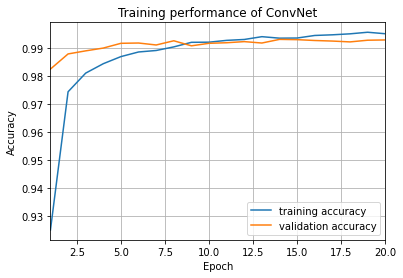

In [13]:
# vector of time
xs = list(range(1, 1 + len(history_cnn.history['accuracy'])))

# Plotting figure
plt.figure()
plt.plot(xs, history_cnn.history['accuracy'], label='training accuracy')
plt.plot(xs, history_cnn.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(1, len(xs))
# plt.ylim(0, 1)
plt.grid()
plt.title("Training performance of ConvNet")
plt.show()

### Discussion:

*   How can you check from those curves if your model overfits?
*   If it overfits, what could you do?


Visualizing the predictions

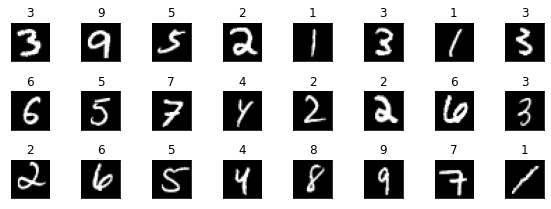

In [14]:
# Plotting random samples from training dataset
plt.figure(figsize=(grid_x, grid_y))

for index in range(grid_x * grid_y):
    plt.subplot(grid_y, grid_x, index + 1)
    img_index = index + 500
    pred_data = np.reshape(x_test[img_index], (1, 28, 28, 1))
    pred = model.predict(pred_data, verbose=0)  
    plt.imshow(np.reshape(x_test[img_index],(img_rows,img_cols)),cmap='gray')
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title(str(np.argmax(pred)))
plt.tight_layout()
plt.show()

# Logistic regression
As a (not entirely fair) comparison, we can also try a logistic regression model. This is basically a one-layer neural network with a sigmoid activation function (well in this case the softmax as we are dealing with a multiclass or multinomial classification problem). However, in practice we would do some feature engineering and most likely not fit raw pixel values into a model. But just to see that you can often consider neural networks as an extension of existing models. 

In [15]:
# Hyperparameters of training
batch_size = 128
epochs = 20

# Defining the logistic regression model in keras
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dropout(0.12),                          # try taking in/out the Dropout layer
        layers.Dense(num_classes, activation='softmax')
    ]
)

Visualizing the model architecture.

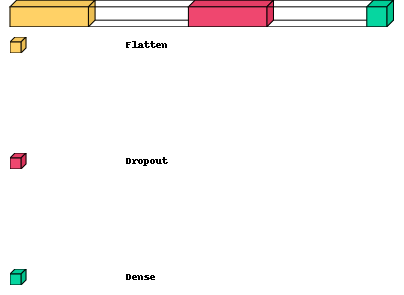

In [16]:
visualkeras.layered_view(model, legend=True, scale_xy=10, scale_z=0.1, draw_volume=True, spacing = 100)

How many parameters in this case? How is it compared to the ConvNet?

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dropout_2 (Dropout)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Compiling and training the logistic regression.

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
# Training the logistic regression on the training dataset.
history_logistic = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(x_test, y_test))

# Running the logistic regression on the test dataset
print("Evaluating the model on the test dataset")
score = model.evaluate(x_test, y_test, verbose=2)

Epoch 1/20
469/469 [==============================] - 2s 3ms/step - loss: 0.6998 - accuracy: 0.8215 - val_loss: 0.3888 - val_accuracy: 0.9009
Epoch 2/20
469/469 [==============================] - 2s 3ms/step - loss: 0.3822 - accuracy: 0.8962 - val_loss: 0.3232 - val_accuracy: 0.9136
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3398 - accuracy: 0.9053 - val_loss: 0.3002 - val_accuracy: 0.9180
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3208 - accuracy: 0.9097 - val_loss: 0.2882 - val_accuracy: 0.9194
Epoch 5/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3097 - accuracy: 0.9130 - val_loss: 0.2823 - val_accuracy: 0.9204
Epoch 6/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3011 - accuracy: 0.9147 - val_loss: 0.2790 - val_accuracy: 0.9212
Epoch 7/20
469/469 [==============================] - 2s 3ms/step - loss: 0.2963 - accuracy: 0.9166 - val_loss: 0.2759 - val_accuracy: 0.9243
Epoch 

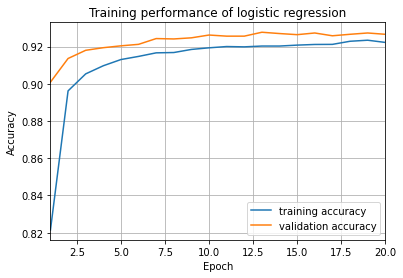

In [20]:
# vector of time
xs = list(range(1, 1 + len(history_logistic.history['accuracy'])))

# Plotting figure
plt.figure()
plt.plot(xs, history_logistic.history['accuracy'], label='training accuracy')
plt.plot(xs, history_logistic.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(1, len(xs))
plt.grid()
plt.title("Training performance of logistic regression")
plt.show()

# Comparing performance of both models
How was the training process for the ConvNet and the Logistic regression? Let's explore it!


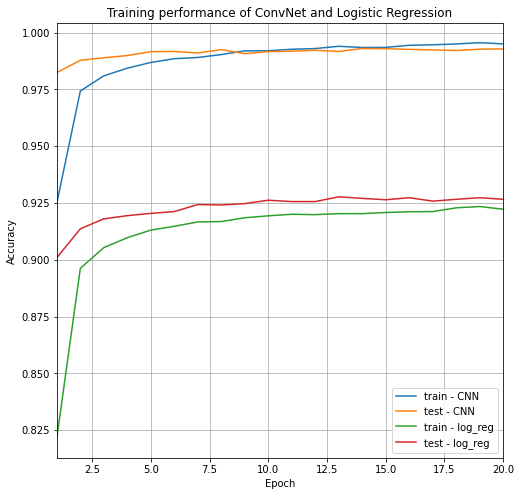

In [73]:
# vector of time
xs = list(range(1, 1 + len(history_cnn.history['accuracy'])))

# Plotting figure
plt.figure(figsize=(8, 8))
plt.plot(xs, history_cnn.history['accuracy'], label='train - CNN')
plt.plot(xs, history_cnn.history['val_accuracy'], label='test - CNN')
plt.plot(xs, history_logistic.history['accuracy'], label='train - log_reg')
plt.plot(xs, history_logistic.history['val_accuracy'], label='test - log_reg')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(1, len(xs))
# plt.ylim(0, 1)
plt.grid()
plt.title("Training performance of ConvNet and Logistic Regression")
plt.show()

# Setup of a convolutional Autoencoder
"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks. Autoencoders are a nonlinear generalization of Principal Component Analysis (PCA). [More info](https://blog.keras.io/building-autoencoders-in-keras.html)

In [21]:
# Hyperparameters of training
batch_size = 128
epochs = 20

# Definition of the model
input = layers.Input(shape=input_shape)
conv2D_1 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(input)
maxPool_1 = layers.MaxPooling2D((2, 2), padding="same")(conv2D_1)
conv2D_2 = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(maxPool_1)
maxPool_2 = layers.MaxPooling2D((2, 2), padding="same")(conv2D_2)

# Decoder
conv2D_3 = layers.Conv2D(3, (3, 3), activation="relu", padding="same")(maxPool_2)
upSam_1 = layers.UpSampling2D((2,2))(conv2D_3)
conv2D_4 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(upSam_1)
upSam_2 = layers.UpSampling2D((2,2))(conv2D_4)
autoencoder = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(upSam_2)

# Autoencoder
autoencoder = Model(input, autoencoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 3)           219   

Visualizing the model architecture.

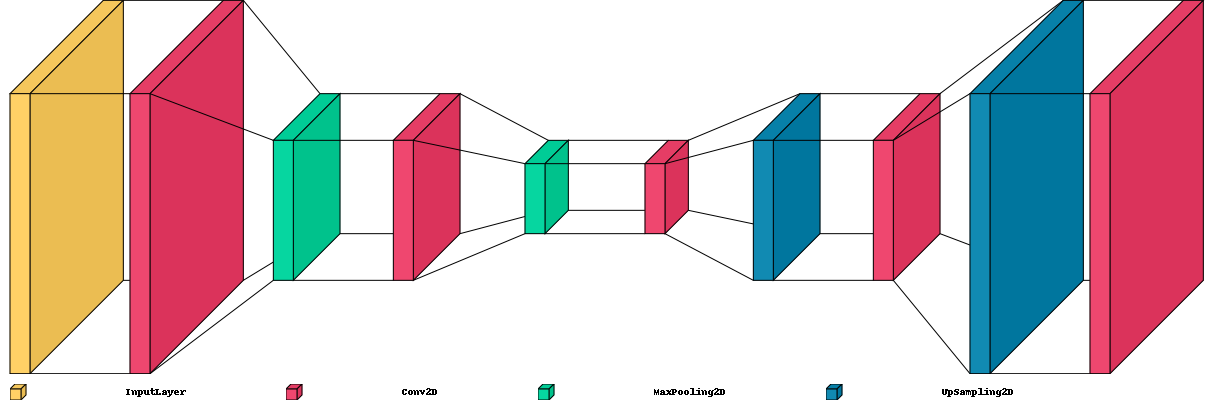

In [22]:
visualkeras.layered_view(autoencoder, legend=True, scale_xy=10, scale_z=0.1, draw_volume=True, spacing = 100)

Compiling and training the convolutional autoencoder.

In [23]:
autoencoder.compile(loss='binary_crossentropy',
                    optimizer='adam', metrics=['accuracy'])

In [24]:
history_c_autoencoder = autoencoder.fit(x_train, x_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, x_test))

Epoch 1/20
469/469 [==============================] - 4s 6ms/step - loss: 0.1702 - accuracy: 0.8080 - val_loss: 0.0971 - val_accuracy: 0.8119
Epoch 2/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0928 - accuracy: 0.8134 - val_loss: 0.0880 - val_accuracy: 0.8127
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0864 - accuracy: 0.8140 - val_loss: 0.0836 - val_accuracy: 0.8133
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0834 - accuracy: 0.8143 - val_loss: 0.0817 - val_accuracy: 0.8135
Epoch 5/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0818 - accuracy: 0.8144 - val_loss: 0.0804 - val_accuracy: 0.8134
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0807 - accuracy: 0.8145 - val_loss: 0.0795 - val_accuracy: 0.8136
Epoch 7/20
469/469 [==============================] - 3s 5ms/step - loss: 0.0799 - accuracy: 0.8146 - val_loss: 0.0788 - val_accuracy: 0.8137
Epoch 

One of the interesting applications of autoeconders is dimensionality reduction. To look how it happens, let's plot the internal representations of the middle layer (the encoder) of this model. We need to create an auxiliar model just for the encoder, then we can depict its output as the dimensionality-reduced representation of the data

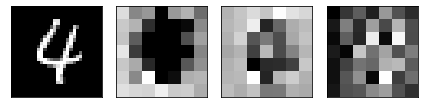

In [25]:
# Creating the model only for the encoding part
encoder = keras.Model(input, conv2D_3)
encoded_imgs = encoder.predict(x_test)

# Index of the input
n = 109

# Plotting the input
fig = plt.figure()
ax = plt.subplot(1, 4, 1)
img_index = n
pred_data = np.reshape(x_test[img_index], (1, 28, 28, 1))
ax.imshow(np.reshape(x_test[img_index],(img_rows,img_cols)),cmap='gray')
    
# Plotting the internal representations of the middle layer
for index in range(1, 4):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(1, 4, index + 1)
    ax.imshow(np.reshape(encoded_imgs[n, :, :, index - 1],(7,7)),cmap='gray')
    # plt.title(str(np.argmax(pred)))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()


### Visualizing the output of the convolutional Autoencoder
To have a qualitative idea of how the autoencoder performs, we can plot and compare its output to inputs.


In [67]:
# Auxiliar function to plot inputs and predictions (outputs) of autoencoder
def draw_predictions_set(predictions):
    plt.figure(figsize=(8, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(x_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.subplot(2, 5, i+6)
        plt.imshow(predictions[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

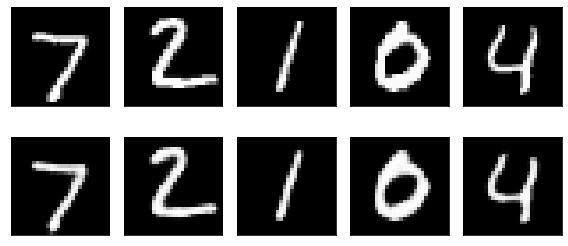

In [27]:
predictions = autoencoder.predict(x_test)
draw_predictions_set(predictions)

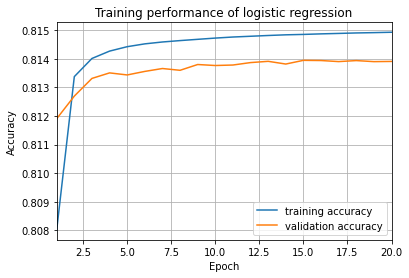

In [28]:
# vector of time
xs = list(range(1, 1 + len(history_logistic.history['accuracy'])))

# Plotting figure
plt.figure()
plt.plot(xs, history_c_autoencoder.history['accuracy'], label='training accuracy')
plt.plot(xs, history_c_autoencoder.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(1, len(xs))
plt.grid()
plt.title("Training performance of logistic regression")
plt.show()

# Setup of a fully connected Autoencoder
A fully connected (or Multilayer Perceptron) Autoencoder for comparison with the CNN model.

In [62]:
num_latent_vars = 20
pixels_per_image = np.prod(x_train.shape[1:])
model = keras.Sequential(
    [
        layers.Dense(num_latent_vars, input_dim=pixels_per_image, activation='relu'),
        layers.Dense(pixels_per_image, activation='sigmoid')
        ]
)

# This is our input image
input_img = keras.Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = layers.Dense(25, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
model = keras.Model(input_img, decoded)
'''
# PCA as a neural network model
model = keras.Sequential(
        [
          layers.Dense(num_latent_vars, input_dim=pixels_per_image, activation='linear'),
          layers.Dense(pixels_per_image, activation='linear')
        ])
'''


"\n# PCA as a neural network model\nmodel = keras.Sequential(\n        [\n          layers.Dense(num_latent_vars, input_dim=pixels_per_image, activation='linear'),\n          layers.Dense(pixels_per_image, activation='linear')\n        ])\n"

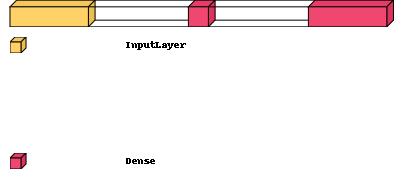

In [63]:
visualkeras.layered_view(model, legend=True, scale_xy=10, scale_z=0.1, draw_volume=True, spacing = 100)

Compiling and training the autoencoder.

In [64]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [65]:
X_train = x_train.reshape((len(x_train), pixels_per_image))
X_test = x_test.reshape((len(x_test), pixels_per_image))
print(X_train.shape)

(60000, 784)


In [66]:
history_fc_autoencoder = model.fit(X_train, X_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(X_test, X_test)) 

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2407 - accuracy: 0.0114 - val_loss: 0.1678 - val_accuracy: 0.0128
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1507 - accuracy: 0.0102 - val_loss: 0.1359 - val_accuracy: 0.0110
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1284 - accuracy: 0.0113 - val_loss: 0.1194 - val_accuracy: 0.0106
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1166 - accuracy: 0.0116 - val_loss: 0.1118 - val_accuracy: 0.0111
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1110 - accuracy: 0.0113 - val_loss: 0.1076 - val_accuracy: 0.0126
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1080 - accuracy: 0.0120 - val_loss: 0.1055 - val_accuracy: 0.0120
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1065 - accuracy: 0.0115 - val_loss: 0.1045 - val_accuracy: 0.0115
Epoch 

### Visualizing the output of the convolutional Autoencoder
To have a qualitative idea of how the autoencoder performs, we can plot and compare its output to inputs.

In [69]:
def draw_predictions_set_flat_input(predictions):
    plt.figure(figsize=(8, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.subplot(2, 5, i+6)
        plt.imshow(predictions[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

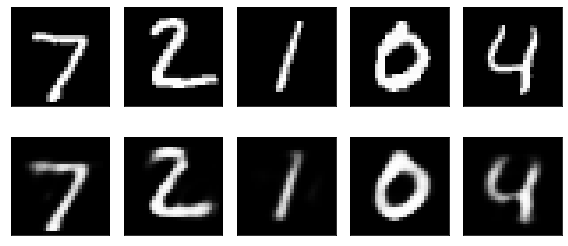

In [70]:
predictions = model.predict(X_test)
draw_predictions_set_flat_input(predictions)

# Comparison of models


In [ ]:
# vector of time
xs = list(range(1, 1 + len(history_cnn.history['accuracy'])))

# Plotting figure
plt.figure(figsize=(10, 10))
plt.plot(xs, history_cnn.history['accuracy'], label='train - CNN')
plt.plot(xs, history_cnn.history['val_accuracy'], label='test - CNN')
plt.plot(xs, history_logistic.history['accuracy'], label='train - log_reg')
plt.plot(xs, history_logistic.history['val_accuracy'], label='test - log_reg')
plt.plot(xs, history_c_autoencoder.history['accuracy'], label='train- CNN_autoencoder')
plt.plot(xs, history_c_autoencoder.history['val_accuracy'], label='test - CNN_autoencoder')
plt.plot(xs, history_fc_autoencoder.history['accuracy'], label='train - autoencoder')
plt.plot(xs, history_fc_autoencoder.history['val_accuracy'], label='test - autoencoder')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(1, len(xs))
# plt.ylim(0, 1)
plt.grid()
plt.title("Training performance of ConvNet")
plt.show()